In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RectBivariateSpline
from codes.plot_utils import plot_pretty, plot_line_points, plot_color_map
from codes.interpolation import polyfit2d, chebyshev_nodes1, chebyshev_nodes2
from codes.cosmology import d_L_romberg
from scipy.interpolate import UnivariateSpline
from HW02_starter import * 
plot_pretty(fontsize=12)
%matplotlib inline

## Exercise 1: Using splines for interpolation and estimates of  derivatives and integrals
### (40 points)

In [4]:
# read in function that will be used for this exercise
k, Pk = np.loadtxt('test_matterpower_logintk1000.dat', usecols=(0, 1),  unpack=True)

# their log10 values that will be used 
lk, lPk = np.log10(k), np.log10(Pk)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


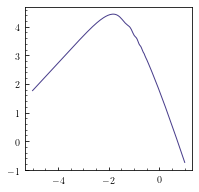

In [3]:
plot_line_points(lk, lPk, figsize = 3)

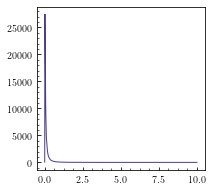

In [4]:
plot_line_points(k, Pk, figsize = 3)


**Task 1a. (10 points)** Based on the code in the 03 notebook reproduced above, write a function that constructs interpolating (using <tt>np.linalg.solve</tt>) or approximating (using <tt>np.linalg.lstsq</tt>) polynomial for input vector of test points and corresponding tabulated function values with the following interface:

Test this function using $\sin(x)$ as a  test function as shown below and demonstrate that your routine works (i.e., produces sensible results). Try changing the number of training points used <tt>ntr</tt> from 20 to smaller values. Identify and report the smallest <tt>ntr</tt> for which you get *interpolating* polynomial that still looks qualitatively as a sine (for example, it has a clear minimum and maximum in the $[0,2\pi]$ interval). Try to come with your interpretation of the meaning of the minimum value that you find and briefly describe it. 

In [3]:
def poly_approx(xtr, ftr, xt, method='interpolation', poly_order=1):
    """
    function constructing an approximating polynomial for the input 
    vector of training values of the approximated function ftr, 
    tabulated at the vector of training points xtr and compute the values
    of constructed polynomial at the input vector of test values xt

    Parameters:
    -----------
    xtr, ftr: array like
                vectors of training points and tabulated function values
    xt: array like
                vector of test points
    method: string
            defining the method to be used in construction of the polynomial
            'interpolation' - construct interpolating polynomial using np.linalg.solve
            'regression' - construct approximating polynomial np.linalg.lstsq
    poly_order: integer
                order of the approximating polynomial. This parameter is ignored
                for method='interpolation', but is used for 'regression'
                must be 0<=poly_order<=np.size(xtr)
    Returns:
    --------
    ft: array like
        values of the polynomial at xt 
    a:  array like
        polynomial coefficients
    """
    
    ntr = np.size(xtr)
    
    if method == 'interpolation':
        V = np.vander(xtr, N = ntr, increasing = True)
        a = np.linalg.solve(V, ftr)
    if method == 'regression':
        if 0 <= poly_order <= ntr:
            V = np.vander(xtr, N = poly_order, increasing = True)
            a = np.linalg.lstsq(V, ftr, rcond = None)[0]
        else:
            raise ValueError('Invalid Polynomial Order')
    
    pfit = np.poly1d(a[::-1])
    ft = pfit(xt)
    
    return ft, a

In [149]:
def test(poly_order, ntr, interpolation = True, regression = False, 
         func = np.sin, xmin = 0, xmax = 2*np.pi, nt = 1000):
    '''
    Returns a plot of a interpolating/regression polynomai for a specified function func
    of a given order poly_order on domain [xmin, xmax] using nt number of test points.
    We train on ntr, the number of training points.
    '''
    # test your routine using code below
    xtr = np.linspace(xmin, xmax, ntr)
    ftr_int = func(xtr)
    # this vector is sine function + a little bit of Gaussian random noise (so mimics approximating noisy data)
    ftr_fit = func(xtr) + np.random.normal(scale=0.05, size=np.size(xtr))
    nt = 1000 # should be different from nt
    xt = np.linspace(xmin, xmax, nt)
    
    if interpolation:
        poly_int, a_int = poly_approx(xtr, ftr_int, xt, method='interpolation')
        plot_line_points(xt, poly_int, xp=xtr, yp=ftr_int, points=True,
                 xlabel=r'$x$', ylabel=r'$f(x)$', figsize=3, plot_title = "Interpolating Polynomial")
    if regression:
        poly_fit, a_fit = poly_approx(xtr, ftr_fit, xt, method='regression', poly_order=poly_order)
        plot_line_points(xt, poly_fit, xp=xtr, yp=ftr_int, points=True,
                     xlabel=r'$x$', ylabel=r'$f(x)$', figsize=3, plot_title = "Regression Polynomial")

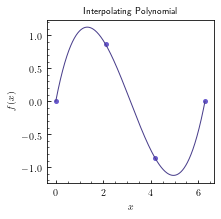

In [10]:
test(poly_order = 3, ntr = 4, regression = False)

**Explanation**:

When the number of training points ntr is 4, we can create a cubic polynomial. Cubic polynomials are the smallest order polynomials that can achieve a local minimum and maximum, so we need a cubic polynomial. Thus, we need 4 training points. 

**Task 1b. (5 points)** Now apply the routine you implemented to interpolate $P(k)$ read in below. If you don't manage to get the working implementation in 1a, you can use <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html"><tt>np.polyfit</tt></a> routine for this exercise. 

If I have time to come back to this, implement the following algorithm to iteratively find the smallest poly_order that achieves a given threshold.

Motivation: Smaller order models are more parsimonious. For task 1b, we see that we have roughly $n \sim 3000$ data points, so we can build a polynomial with order up to $n - 1$. However, a polynomial of much smaller order is often "good-enough" for modeling purposes. So, we attempt to find what order corresponds to "good-enough". 

**ALGORITHM**: 

    """
    L2_change represents the change in L2_loss as we increase the poly_order by 1. 
    This can be fractional or absolute change depending on the user's specification. 
    When the change is smaller than the threshold, we don't get much improvement by 
    increasing the order, so we end the loop and keep the current model.
    """

     * If interpolating: Split the training points into training and testing datasets.
     We do this since we can't compute loss without y_test values. 
     * If regression: Pass. We can compute the L2 loss directly.
     
     """
    While L2_change > THRESH:
     * Use poly_fit to get predicted_test values.
     * Store coefficients of model from poly_fit.
     * Compute L2_loss_new (residual sum of squares).
     * If L2_loss_prev is None (happens when we first run the loop since it's
       not initialized yet): Set L2_loss_prev = L2_loss_new.
     * L2_change = L2_loss_new / L2_loss_new
     * L2_loss_prev = L2_loss_new. 
     * poly_order = poly_order + 1
    """
    
    Return coefficients
    
**Areas of Improvement**:
* Cross-Validation instead of Train-Test-Split if number of samples is low. 
* To handle splines, we can either:
    * Optimize number of nodes (for natural cubic splines)
    * Use regularization to avoid over-fitting (for smoothing splines)
    
**Good Notes to Study Splines**:
* https://www.stat.cmu.edu/~cshalizi/402/lectures/11-splines/lecture-11.pdf (Cosma Shalizi is a legend!)

In [59]:
def poly_data_interpolate(xtr, ytr, nkt, poly_order, method):
    '''
    Potential Improvement: The distribution of Pk is not uniform,
    so a linear slice pattern would also not be uniform. A method
    that slices more at the end (where the data is more sparse)
    compared to the beginning may be more ideal.
    '''
    xt = np.linspace(xtr.min(), xtr.max(), nkt)  
    poly_int, a_int = poly_approx(xtr, ytr, xt, method = method, poly_order = poly_order)
    return xt, poly_int

In [60]:
xt, poly_int = poly_data_interpolate(k[::], Pk[::], 1000, np.size(k), "interpolation")
np.isnan(poly_int).sum() # So all poly_int values are nan.

1000

The interpolation matrix is too large (so taking the inverse is compuationally infeasible) if we use all of the data in (k, Pk).

### What happens when we interpolate/regress on $(k, P_k)$?

#### Interpolation

In [61]:
a = np.arange(0, 80, 2)
b = np.where((lk > -1.5) & (lk < -.5))
c = np.where(80, 300, 2)
d = np.arange(300, np.size(k), 15)
ind = np.concatenate((a, b, c, d), axis = None)

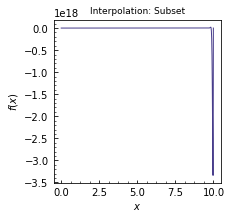

In [68]:
# By inspection, we see that sampling every sample (or even every 10th sample) is infeasible.
# We reduce the number of points below.
xt, poly_int = poly_data_interpolate(k[ind], Pk[ind], 1000, np.size(ind), "interpolation")
np.isnan(poly_int).sum() # So none of the poly_int values are nan.
plot_line_points(xt, poly_int, xlabel=r'$x$', ylabel=r'$f(x)$', figsize=3, plot_title = "Interpolation: Subset")

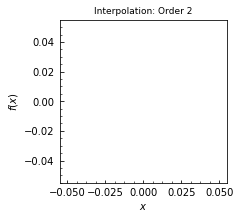

In [67]:
# Reducing the order of the polynomial doesn't help.
xt, poly_int = poly_data_interpolate(k[::], Pk[::], 1000, 2, "interpolation")
np.isnan(poly_int).sum() # So none of the poly_int values are nan.
plot_line_points(xt, poly_int, xlabel=r'$x$', ylabel=r'$f(x)$', figsize=3, plot_title = "Interpolation: Order 2")

#### Regression

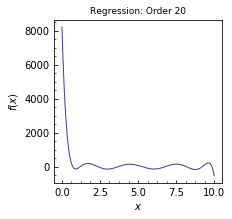

In [64]:
# For regression, making a polynomial of order np.size(k) is not feasible as the SVD
# doesn't converge. We reduce the order to 20. 
xt, poly_int = poly_data_interpolate(k, Pk, 1000, 10, "regression")
plot_line_points(xt, poly_int, xlabel=r'$x$', ylabel=r'$f(x)$', figsize=3, plot_title = "Regression: Order 20")

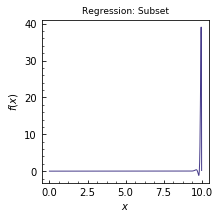

In [66]:
# We can also resolve this issue by taking a subset.
xt, poly_int = poly_data_interpolate(k[ind], Pk[ind], 1000, 200, "regression")
plot_line_points(xt, poly_int, xlabel=r'$x$', ylabel=r'$f(x)$', figsize=3, plot_title = "Regression: Subset")

### What happens? Try doing this for $\log_{10} k$ and $\log_{10} P(k)$ instead of $P(k)$. Then try with regression. 

Both approxmations are pretty bad, but regression performs better. We reduce the number of training points since inverting the Vandermonde matrix became infeasible otherwise. We partition the dataset in a way that captures more points towards the beginning, which changes more, compared to the end, which is relatively more flat. 

The shapes of the polynomials are not perfect. Regression came close but yielded $P(k)$ values an order of magnitude lower. 
The shape of the interpolating polynomial was not correct; the peak near 0 was not captured.

A 10th order polynomial from regression is a reasonable approximation.

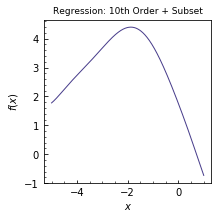

In [73]:
xt, poly_int = poly_data_interpolate(lk[ind], lPk[ind], 1000, 10, "regression")
plot_line_points(xt, poly_int, xlabel=r'$x$', ylabel=r'$f(x)$', figsize=3, plot_title = "Regression: 10th Order + Subset")

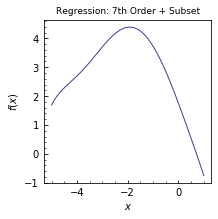

In [71]:
xt, poly_int = poly_data_interpolate(lk[ind], lPk[ind], 1000, 7, "regression")
plot_line_points(xt, poly_int, xlabel=r'$x$', ylabel=r'$f(x)$', figsize=3, plot_title = "Regression: 7th Order + Subset")

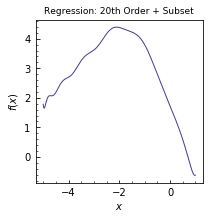

In [72]:
xt, poly_int = poly_data_interpolate(lk[ind], lPk[ind], 1000, 20, "regression")
plot_line_points(xt, poly_int, xlabel=r'$x$', ylabel=r'$f(x)$', figsize=3, plot_title = "Regression: 20th Order + Subset")

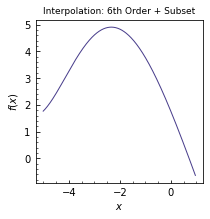

In [75]:
xt, poly_int = poly_data_interpolate(lk[::600], lPk[::600], 1000, np.size(lk[::600]), "interpolation")
plot_line_points(xt, poly_int, xlabel=r'$x$', ylabel=r'$f(x)$', figsize=3, plot_title = "Interpolation: 6th Order + Subset")

**Do you get a sensible result? Think about what the routine is doing and try to come up with an explanation for the outcome of this exercise. (7 points)**

**Try regression with smaller poly_order values and find polynomial order for which at least somewhat sensible approximation can be obtained. What is that order? Think about a possible explanation for why this works for small order (3 points).**

The shape of the interpolation plot is better, but we can't capture the behavior of the function around $\log_{10}(k)=-1$. I attempted to do so by retaining all of the points the capture this behavior in my subset. However, it still wasn't enough.

We probably got a better result because the changes in $\log_{10}(P(k))$ were move evenly spaced compared to changes in $P(k)$. 
Anyways, increased stability in the function allowed us to retain most of the information even while reducing the number of training points. 

Regarding the ideal poly_order value, I think a poly_order of 10 is most ideal since the plot looks like it obeys the power law to the left side of the peak (i.e. we see a linear-like relationship between $\log_{10}(k)$ and $\log_{10}(P(k))$. If we try any order lower than this, then we see fluctuations on the left side of the peak. 


Here is the test that the spline interpolation produces good results for interpolation of <tt>Plk</tt> as a function of <tt>lk</tt>

**Task 1c. (10 points)** Add calculation of the first, second, and third derivatives based on the spline interpolation to the routine <tt>cubic_spline</tt> above (3 points). Write a routine to estimate integral of $f(x)$ in the interval $[a,b]$ using interpolating cubic spline for $f(x)$ and its coefficient vectors $a$, $b$, $c$, $d$. (4 points).

Plot the first three derivatives for some function (for example, the sine) and comment on their behavior (smoothness, continuity). Test the accuracy of the integral for a function for which you know the exact answer (e.g., $\sin x$ or $e^x$.) (3 points). 

The routines are in the file `HW02_starter.py`.

In [5]:
def cubic_spline_test(xi, func, exact_int):
    '''
    Plots 1st, 2nd, and 3rd derivatives of
    a given function func using the user's 
    specified training points xi. 
    
    Exact_int is the exact value of the integral
    of this function on the interval specified by
    the training points.
    
    We print the fractional error of the integral after
    plotting the derivatives.
    '''
    xt = np.linspace(xi.min(), xi.max(), xi.size*10)
    fi = func(xi)
    CS = Cubic_Spline(xi, fi)
    d1 = CS.derivative(xt); d2 = CS.derivative(xt, 2)
    d3 = CS.derivative(xt, 3)
    approx_int = CS.integral(xi.min(), xi.max(), xi[1] - xi[0])
    frac_err = abs(1 - approx_int / exact_int) * 100
    
    plot_line_points(x = xt, y = d1, plot_title = "1st Derivative")
    plot_line_points(xt, d2, plot_title = "2nd Derivative")
    plot_line_points(xt, d3, plot_title = "3rd Derivative")
    print("Relative Error of Integral: {} %".format(frac_err))
    return None

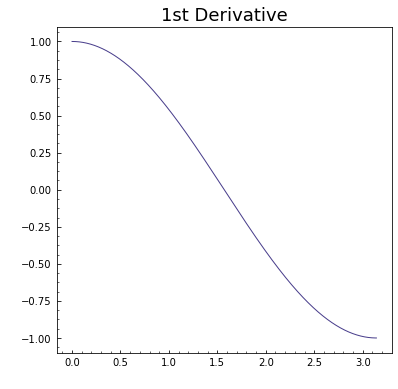

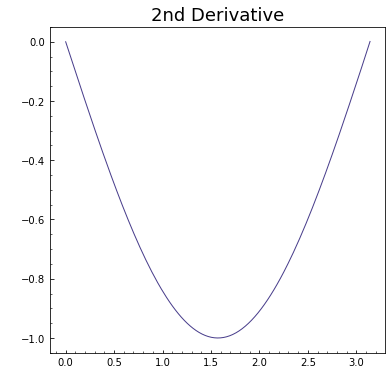

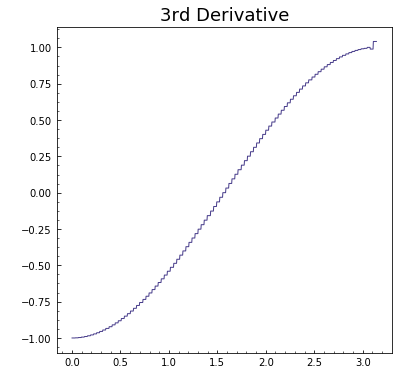

Relative Error of Integral: 1.7992477507888793e-07 %


In [6]:
cubic_spline_test(np.linspace(0, np.pi, 100), np.sin, 2)

The first derivative is continuous and differentiable. 

Since the second derivative is not differentiable everywhere (it loses differentiability where the third derivative is not continous). We can still find one-sided derivatives however. 

The third derivative is a step-function, so there are discontinuities. We can compute the derivative at all points except the corners. 
Increasing the number of training points increases the number of steps, which makes the curve appear more smooth.

The integral is accurate.

**Task 1d. (5 points)** Suppose we want to compute the *logarithmic slope* of $P(k)$:

$$\frac{d\log_{10}P}{d\log_{10} k}=\frac{d\ln P}{d\ln k}=\frac{k}{P}\,\frac{dP}{dk}.$$

Compute this derivative using your routine implemented in 1c using <tt>lk</tt> and <tt>lPk</tt> vectors and plot this derivative as a function of <tt>lk</tt>. Compare your plot to the left panel of Figure 4 in <a href="https://arxiv.org/pdf/1407.4730">this paper</a>. It should look roughly similar, but with some differences. Describe the differences. Briefly describe what causes them. 

Note that if you don't complete 1c, you can construct spline interpolation of <tt>lk</tt> and <tt>lPk</tt> using SciPy <tt>UnivariateSpline</tt> with <tt>s=0</tt> and use its <tt>derivative()</tt> method to compute the derivative (see Task 1e below). 

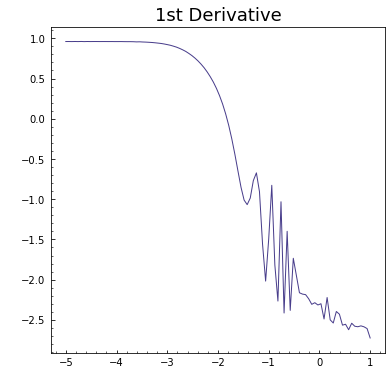

In [9]:
def spl_deriv_plot(xi, yi, ntr = 100, order = 1):
    '''
    Plots derivative of a given order for a cubic
    spline computer using the training data (xi, yi).
    
    We can subset this data using ntr.
    '''
    xt = np.linspace(xi.min(), xi.max(), ntr)
    CS = Cubic_Spline(xi, yi)
    d1 = CS.derivative(xt, order)
    plot_line_points(x = xt, y = d1, plot_title = "1st Derivative")
    return None

spl_deriv_plot(lk, lPk)

**Discussion**: We see that the log-log plot above roughly matches the figure in the paper in terms of shape. Both capture the behavior around lk = -1 (on the log scale). The behavior of the function here made it difficult for us to construct a good approximation. 

My plot have some fluctuations between 0 and 1 on the x-axis. This is not found in the plot in the paper. 

It's a little hard to compare the two plots since the domains are different -- mine being $[-5, 1]$ and the paper's being $[-1, 6]$ (on a log-scale). There is noticably more noise in my plot compared to the paper's; however, the approximation still apepars to follow the power law. 

**Task 1e (5 points)** Use SciPy <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.UnivariateSpline.html"><tt>UnivariateSpline</tt></a> routine to approximate <tt>lk</tt> and <tt>lPk</tt> and this class'  <tt>derivative()</tt> method to construct approximation for the derivative, as illustrated below, to compute the derivative $$\frac{d\log_{10}\left(P\right)}{d\left(\log_{10} k\right)}.$$ Compute and plot the derivative for <tt>s=0.</tt>, <tt>s=0.0001</tt>, <tt>s=0.001</tt>, and <tt>s=0.01</tt> and comment on how the derivative changes for different values of the smoothing parameter <tt>s</tt>. Try to explain the behavior you observe. 

In [82]:
def univar_spline_plot(lk, lPk, S, nkt = 1000):
    '''
    Computes a spline with smoothing factor S using the training data
    (lk, lPk). We compute the derivative on the interval specified
    by lK, nkt number of equally spaced points.
    
    We plot the derivative below.
    '''
    lkt = np.linspace(lk.min(), lk.max(), nkt)
    
    for val in S:
        spl = UnivariateSpline(lk, lPk, s = val)
        dspl = spl.derivative()

        plot_line_points(lkt, dspl(lkt), xlabel=r'$\log_{10} k$', ylabel=r'$\log_{10}P(k)$', 
                         figsize=3, plot_title = "s = {}".format(val))

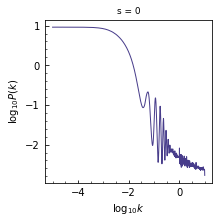

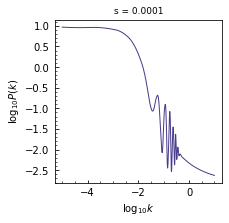

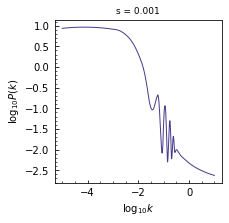

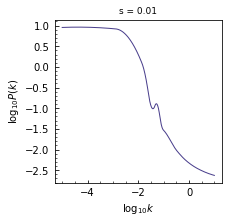

In [83]:
univar_spline_plot(lk, lPk, [0, 0.0001, 0.001, 0.01])

In the $s = 0$ case and for othe other values of $s$ that we tested, we see that the spline is not as smooth around $k = 0.1$ as the value of $s$ decreases.

The $s = 0$ case corresponds to the derivative of the cubic spline (using all of the lk test points), which is why it matches the plot we saw earlier since the $s = 0$ is an interpolation through all training points. 

As we increase $s$, the spline interpolates through less points (nodes), but applies a least-squares approximation. This lessens over-fitting but consequently loses some of the finer details captured by using all of the training points. 

**Task 1f. (5 points)** Using spline to invert function. Using spline we can invert a function or, for $y=f(x)$ compute $x$ for a given $y$. For this we need to generate vectors of $x$ and $y$ and construct interpolating spline for $y$ as the argument and $x$ as a function value. The spline can then be used for input $y$ values to estimate corresponding $x$. ***This, of course, assumes that function is monotonic and that a unique value of $x$ can be obtained for a given $y$.*** So these assumptions must be satisfied for this approach to work.  

Construct interpolating spline for $y=\sin(x)$ on the interval $[0,\pi/2]$ and use it to compute $x$ for $y=1$, $y=0$, $y=0.5$. Compare the values you get to the output of <tt>np.arcsin</tt> for these values of $y$. 

In [20]:
def inverse_solve(xtr, func, y):
    '''
    Input training data xtr and a function func and a given y.
    Goal: Find x such that f(x) = y.
    Idea: Compute spline for the inverse function f^-1(y) = x. 
    And interpolate to find estimate the x that corresponds to y.
    
    Assumptions: The function is monotonic, so we get uniqueness of
    such an x value if such an x exists. 
    
    To prove existence, plot a few points and apply the
    intermediate value theorem . 
    '''
    
    ftr = func(xtr)
    CS = Cubic_Spline(ftr, xtr)
    ft = CS.cubic_spline(np.array([y, y*1.1]))
    return ft[0]

In [21]:
inverse_solve(np.linspace(0, np.pi / 2, 100), np.sin, 0)

0.0

In [22]:
inverse_solve(np.linspace(0 , np.pi / 2, 100), np.sin, .5)

0.5235987755982989

In [23]:
inverse_solve(np.linspace(0, np.pi / 2, 100), np.sin, 1)

1.5707963267948966

## Exercise 2 (30 points)

**Task 2a. (15 points)** Write a routine that constructs 2D *spline* approximation of $\tilde{d}_L(z,\Omega_{\rm m0}, \Omega_\Lambda)$ for a given input single value of redshift $z$ and for ranges of the $\Omega_{\rm m0}$ and $\Omega_\Lambda)$ parameters of $\Omega_{\rm m0}\in [0.1]$ and $\Omega_\Lambda\in[0.,1]$. Experiment with different training point spacings (for example, evenly spaced vs Chebyshev nodes) and try to find the spacing that reaches the target fractional accuracy of $10^{-4}$ with the smallest size of the training set for any $z$ in the interval $z\in [0,2]$. 

In [12]:
def dL_tilda(z, Om0, OmL, atol, rtol):
    """
    Input z, Om0, OmL, atol, rtol (parameters of d_L).
    Returns integral from z to 1 using recursive romberg scheme. 
    """
    c = 299792458
    return d_L_romberg(z, 1, Om0, OmL, atol = atol, rtol = rtol) / c

def dL_spline(z, spacing = 'chebyshev1', ntr = 13):
    """
    Returns 2D-spline for the function dL_tilda. 
    We build training points below based on the specified 
    spacing method. The number of training points is specified by ntr.
    """
    Om0tr_min, Om0tr_max = 0., 1.
    OmLtr_min, OmLtr_max = 0., 1.
    if spacing == 'chebyshev1':
        Om0tr = chebyshev_nodes1(Om0tr_min, Om0tr_max, ntr)[::-1]
        OmLtr = chebyshev_nodes1(OmLtr_min, OmLtr_max, ntr)[::-1]
    elif spacing == 'chebyshev2':
        Om0tr = chebyshev_nodes2(Om0tr_min, Om0tr_max, ntr)[::-1]
        OmLtr = chebyshev_nodes2(OmLtr_min, OmLtr_max, ntr)[::-1]
    elif spacing == 'even':
        Om0tr = np.linspace(Om0tr_min, Om0tr_max, ntr)        
        OmLtr = np.linspace(OmLtr_min, OmLtr_max, ntr)
    else:
        raise ValueError('Error: Spacing method invalid')

    ftr = np.array([np.array([dL_tilda(z, i, j, 1e-6, 1e-6) for j in OmLtr]) for i in Om0tr])
    spl2D = RectBivariateSpline(Om0tr, OmLtr, ftr, s = 0., kx = 3, ky = 3)
    
    return spl2D

In [116]:
def node_comparison(method, ntr = 13, nt = 100):
    """
    Input: Spacing method, number of traning points, number of test points
    Output: Plot Color Map of spline_approxmation
                              frac_error
                              log(frac_error)
            plotted against Om0gy, OmLgt
    Spacing method: chebyshev1, chebyshev2, even
    """
    ######DEFINE PARAMETERS#######
    z = 2
    Om0t = np.linspace(1e-3, 1, nt); OmLt = np.linspace(1e-3, 1, nt)
    Om0gt, OmLgt = np.meshgrid(Om0t, OmLt, sparse=False, indexing='ij')
    dL_sp2D = dL_spline(z,spacing = method, ntr = ntr)
    dL_approx = dL_sp2D(Om0t, OmLt)

    ######COLOR MAP#######
    plot_color_map(Om0gt, OmLgt, dL_approx, xlim=[0.,1.], ylim=[0.,1.], 
                   xlabel = '$Om0$', ylabel = '$OmL$', cmap='plasma', colorbar=True, 
                   plot_title = method + ' spline approximation',
                   figsize=3.0)

    ######Fractional Error Computation#######
    log_ferr, ferr = np.meshgrid(np.zeros(nt), np.zeros(nt), sparse=False, indexing='ij')
    for i in range(nt):
        for j in range(nt):
            d_exact = d_L_romberg(z, 1., Om0t[i], OmLt[j], 1e-14, 1e-14) /299792458
            ferr[i][j] = np.abs(1 - dL_approx[i][j] / d_exact)
            log_ferr[i][j] = np.log10(ferr[i][j])

    ferr2 = np.array(ferr); log_ferr2 = np.array(log_ferr)
    print(method + ' Max Frac_Error = ' + str(ferr.max()))

    ######Fractional Error Plot#######
    plot_color_map(Om0gt, OmLgt, log_ferr2, xlim=[0.,1.], ylim=[0.,1.], 
                   xlabel = '$Om0$', ylabel = '$OmL$', cmap='plasma', colorbar = True, 
                   plot_title=method + r' $log_{10}$ spline frac_error', 
                   figsize=3.0)
    plot_color_map(Om0gt, OmLgt, ferr2, xlim=[0.,1.], ylim=[0.,1.], 
                   xlabel = '$Om0$', ylabel = '$OmL$', cmap='plasma', colorbar = True, 
                   plot_title=method + r' spline frac_error',
                   figsize=3.0)

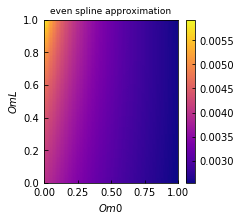

even Max Frac_Error = 0.00529628847663921


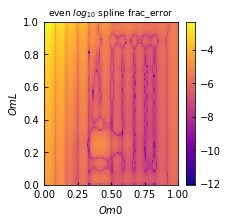

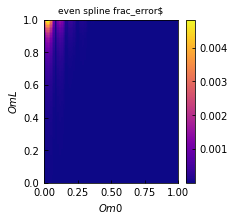

In [37]:
node_comparison("even", 13)

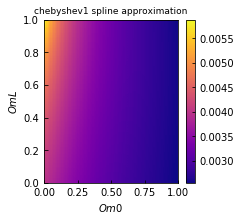

chebyshev1 Max Frac_Error = 0.010225479398974446


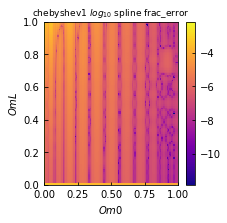

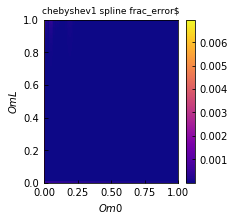

In [38]:
node_comparison("chebyshev1", 13)

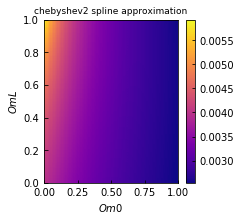

chebyshev2 Max Frac_Error = 0.0003665838036981395


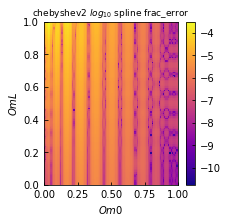

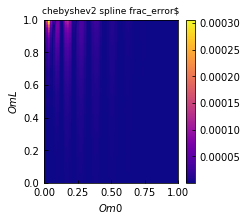

In [40]:
node_comparison("chebyshev2", 13)

In [115]:
def num_train_comparison(method, ntr_max = 25, nt = 100, verbose = False):
    """
    Inputs:
        method of spacing: chebyshev2, chebyshev, even
        ntr_max: maximum number of training points
        nt: number of test points
        verbose: True if you want print statements
    
    Plots number of training points against log fractional error. 
    """
    frac_errors = np.empty(ntr_max)
    iters = np.arange(3, ntr_max + 1)
    bk = ntr_max
    
    for k in range(3, ntr_max + 1):
        ######DEFINE PARAMETERS#######
        z = 2
        Om0t = np.linspace(0.05,.95, nt); OmLt = np.linspace(0.05,.95, nt)
        Om0gt, OmLgt = np.meshgrid(Om0t, OmLt, sparse=False, indexing='ij')
        try:
            dL_sp2D = dL_spline(z,spacing = method, ntr = k)
        except:
            if verbose: print("Error: Can't calculate spline for {} training points. Next iteration.".format(k))
            continue
        dL_approx = dL_sp2D(Om0t, OmLt)

        ######Fractional Error Computation#######
        log_ferr, ferr = np.meshgrid(np.zeros(nt), np.zeros(nt), sparse=False, indexing='ij')
        for i in range(nt):
            for j in range(nt):
                d_exact = d_L_romberg(z, 1., Om0t[i], OmLt[j], 1e-14, 1e-14) /299792458
                ferr[i][j] = np.abs(1 - dL_approx[i][j] / d_exact)
                log_ferr[i][j] = np.log10(ferr[i][j])

        ferr2 = np.array(ferr); log_ferr2 = np.array(log_ferr)
        max_err = ferr.max()
        frac_errors[k - 3] = np.log10(max_err)
        
        if max_err < 1e-4:
            bk = k
            if verbose:
                print(k, max_err)
                print()
                print("Threshold Hit at n = {} training points".format(k))
            break
        if verbose: print(k, max_err)
    iters, frac_errors = iters[:bk], frac_errors[:(iters[:bk].size)]
    plt.scatter(iters[:bk - 2], frac_errors[:(iters[:bk - 2].size)])
    plt.title("Ideal Number of Training Points for {} method".format(method))
    plt.xlabel("Number of Training Points")
    plt.ylabel("Max Log Fractional Error")
    plt.axhline(y = -4, color = "r", linestyle = "--")
    plt.show()

3 0.04058575638996875
4 0.02447373673209452
5 0.014116163372158486
6 0.007780893410343048
7 0.004256864972877805
8 0.002351853111357327
9 0.001324707927394253
10 0.0007638054037997222
11 0.00044693992481215084
12 0.0002127546482832976
13 8.714147056376742e-05

Threshold Hit at n = 13 training points


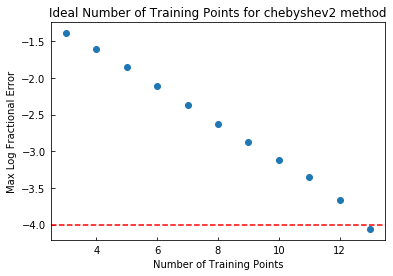

In [109]:
num_train_comparison("chebyshev2", ntr_max = 25)

3 0.023170620295772215
4 0.013834192811778223
5 0.00841806681881474
6 0.005099093904870067
7 0.0030836862404899357
8 0.001982608828600907
9 0.0012796130355307023
10 0.000823365842400503
11 0.0005400692243796579
12 0.00035582181013149583
13 0.00023908475228395787
14 0.00014128827435444524
15 5.9767793399667646e-05

Threshold Hit at n = 15 training points


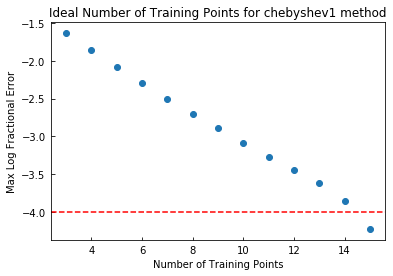

In [108]:
num_train_comparison("chebyshev1", ntr_max = 25)

Error: Can't calculate spline for 3 training points. Next iteration.
4 0.04978773344082099
5 0.029523875935566046
6 0.02015301510966383
7 0.014412954451424431
8 0.010565670142213879
9 0.007790901198891698
10 0.0057614017387404015
11 0.004258642922524203
12 0.003136775439222639
13 0.0022944092780601277
14 0.0016590758683385776
15 0.0011794440016819063
16 0.0008174519387946777
17 0.0005450406157765375
18 0.00042648715495730016
19 0.00035738761305703637
20 0.0003211525007601468
21 0.0002789672548172417
22 0.0002498081463488955
23 0.00021410779334818386
24 0.00019190019269932357
25 0.00017468218751282016


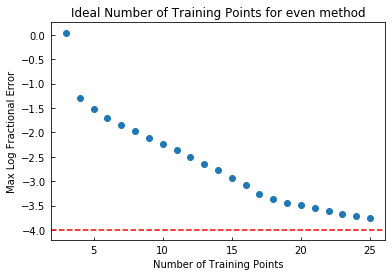

In [114]:
num_train_comparison("even", ntr_max = 25)

**Discussion**: 

**Accuracy**: From our group presentation, 2nd order Chebyshev nodes are most effective of meeting the fractional error threshold with the fewest possible training points (13 using a 3rd order spline). Above I see that for 13 training points, chebyshev 2 performs best, followed by evenly-spaced and Chebyshev 1.

**Number of Points**: Chebyshev 2 reaches the target accuracy in the fewest number of points. Chebyshev 1 did next best. Evenly spaced was not able to reach the limit using 25 training points. 

**Task 2b (15 points).** Although there is no convenient Scipy routine for polynomial interpolation in 2d, we can use the same approach as was used in Task 1a to construct interpolating polynomial in 2d, as is done in the following routine (a modified version of the routine provided <a href="https://stackoverflow.com/questions/33964913/equivalent-of-polyfit-for-a-2d-polynomial-in-python">here</a>). 

Write a routine that constructs 2D *polynomial* approximation of $\tilde{d}_L(z,\Omega_{\rm m0}, \Omega_\Lambda)$ for a given input single value of redshift $z$ and for ranges of the $\Omega_{\rm m0}$ and $\Omega_\Lambda)$ parameters of $\Omega_{\rm m0}\in [0.1]$ and $\Omega_\Lambda\in[0.,1]$. Just like for the spline in 2a, experiment with different training point spacings (for example, evenly spaced vs Chebyshev nodes) and try to find the spacing that reaches the target fractional accuracy of $10^{-4}$ with the smallest size of the training set for any $z$ in the interval $z\in [0,2]$. 

State your conclusions about the optimal method for approximating $\tilde{d}_L(z,\Omega_{\rm m0}, \Omega_\Lambda)$ supporting it with tests of fractional accuracy and plots, as needed. Each of the groups will make a brief presentation of their results in class Friday of next week.

In [121]:
def dL_poly_approx(z, spacing = 'chebyshev1', ntr = 11, kx = 11, ky = 11):
    """
    Returns regression polynomial for the function dL_tilda. 
    We build training points below based on the specified 
    spacing method. The number of training points is specified by ntr.
    The order of the polynomial is specified by (kx, ky). 
    """
    Om0tr_min, Om0tr_max = 0., 1
    OmLtr_min, OmLtr_max = 0., 1
    
    Om0tr, Omltr = [], []
    
    if spacing == 'chebyshev1':
        Om0tr = chebyshev_nodes1(Om0tr_min,Om0tr_max,ntr)[::-1]
        OmLtr = chebyshev_nodes1(OmLtr_min,OmLtr_max,ntr)[::-1]
    elif spacing == 'chebyshev2':
        Om0tr = chebyshev_nodes2(Om0tr_min,Om0tr_max,ntr)[::-1]
        OmLtr = chebyshev_nodes2(OmLtr_min,OmLtr_max,ntr)[::-1]
    elif spacing == 'even':
        Om0tr = np.linspace(Om0tr_min, Om0tr_max, ntr)
        OmLtr = np.linspace(OmLtr_min, OmLtr_max, ntr)
    else:
        raise ValueError('Error: Spacing method invalid')

    ftr = np.array([np.array([dL_tilda(z, i, j, 1e-14, 1e-14) for j in OmLtr]) for i in Om0tr])
    poly2D = polyfit2d(Om0tr, OmLtr, ftr, kx = kx, ky = ky, order = None)
    
    return poly2D

In [146]:
def node_comparison2(method, ntr = 13, nt = 100, px = 11, py = 11, plot = False):
    """
    See the node_comparison above. 
    Modifications:
        px, py = order of polynomial
        plot: if true, produce plots (same kind as those in node_comparison)
    """
    ######DEFINE PARAMETERS#######
    z = 2
    Om0t = np.linspace(1e-3, 1, nt); OmLt = np.linspace(1e-3, 1, nt)
    Om0gt, OmLgt = np.meshgrid(Om0t, OmLt, sparse = False, indexing='ij')
    
    dL_coeffs = dL_poly_approx(z, method, ntr, px, py)
    dL_approx = np.polynomial.polynomial.polyval2d(Om0gt, OmLgt, dL_coeffs.reshape((px + 1,py + 1)))

    ######COLOR MAP#######
    if plot: plot_color_map(Om0gt, OmLgt, dL_approx, xlim=[0.,1.], ylim=[0.,1.], 
                   xlabel = '$Om0$', ylabel = '$OmL$', cmap='plasma', colorbar=True, 
                   plot_title = method + ' polynomial approximation',
                   figsize=3.0)

    ######Fractional Error Computation#######
    log_ferr, ferr = np.meshgrid(np.zeros(nt), np.zeros(nt), sparse=False, indexing='ij')
    for i in range(nt):
        for j in range(nt):
            d_exact = d_L_romberg(z, 1., Om0t[i], OmLt[j], 1e-14, 1e-14) /299792458
            ferr[i][j] = np.abs(1 - dL_approx[i][j] / d_exact)
            log_ferr[i][j] = np.log10(ferr[i][j])

    ferr2 = np.array(ferr); log_ferr2 = np.array(log_ferr)
    # print(method + ' Max Frac_Error = ' + str(ferr.max()))

    ######Fractional Error Plot#######
    if plot:
        plot_color_map(Om0gt, OmLgt, log_ferr2, xlim=[0.,1.], ylim=[0.,1.], 
                   xlabel = '$Om0$', ylabel = '$OmL$', cmap='plasma', colorbar = True, 
                   plot_title=method + r' $log_{10}$ polynomial frac_error', 
                   figsize=3.0)
        plot_color_map(Om0gt, OmLgt, ferr2, xlim=[0.,1.], ylim=[0.,1.], 
                       xlabel = '$Om0$', ylabel = '$OmL$', cmap='plasma', colorbar = True, 
                       plot_title=method + r' polynomial frac_error',
                       figsize=3.0)
    return ferr.max()

By inspection, I found that a 13th order polynomial with 13 training points on chebyshev1 nodes achieved the threshold. 
In order to find a more parsimonious model, I ignore higher order polynomials. Instead, I search through all polynomials with order 12 or under and see if any can meet the threshold with less than 13 points. By changing the "even" parameter to the other methods of spacing nodes ("chebyshev1", "chebyshev2"), I can account for the spacing parameter.

The minimum values for order and number of training points below are arbitrary. From experimentation, I concluded that a model that meets the threshold exists with polynomials of order less than 5 or with less than 5 training points. 

In [152]:
for order in range(5, 14):
    for num_tr in range(6, 14):
        if node_comparison2("even", ntr = num_tr, px = order, py = order) <= 1e-4:
            print(order, num_tr)

Unfortunately, this loop yields nothing. 

Now, forget about finding a parsimonious model. I search through polynomials of order between 13 and 20 (I need a cutoff somewhere so I picked 20) and see if there exists any polynomial that uses less than 13 training points.

In [153]:
for order in range(13, 20):
    for num_tr in range(6, 14):
        if node_comparison2("chebyshev1", ntr = num_tr, px = order, py = order) <= 1e-4:
            print(order, num_tr)

13 13


In [154]:
for order in range(13, 20):
    for num_tr in range(6, 14):
        if node_comparison2("chebyshev2", ntr = num_tr, px = order, py = order) <= 1e-4:
            print(order, num_tr)

In [155]:
for order in range(13, 20):
    for num_tr in range(6, 14):
        if node_comparison2("even", ntr = num_tr, px = order, py = order) <= 1e-4:
            print(order, num_tr)

The loops above show that we can't find a polynomial with an order less than 20 and uses less than 13 training points. 

In [156]:
node_comparison2("chebyshev1", ntr = 13, px = 13, py = 13)

9.8831032248059e-05

Chebyshev 1 Max Frac_Error = 9.158131973074912e-05


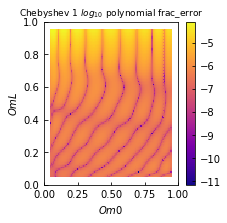

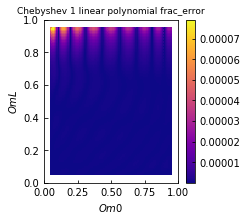

In [28]:
dL_coeffs_chb1 = dL_poly_approx(z, spacing = 'chebyshev1')
dL_approx_chb1 = np.polynomial.polynomial.polyval2d(Om0gt, OmLgt, dL_coeffs_chb1.reshape((px + 1,py + 1)))

**Discussion**: For regression, we find that the best method is a polynomial approximation using Chebyshev nodes of the first kind (Chebyshev 1 nodes) with 13 training points. But since this had a smaller greater fractional error compared to our best output for splines, I think we should go with the model from splines (chebyshev2 with 13 training points).

### Exercise 3 (extra-credit, 10 points): implementing spline interpolation as a Python class

Implementing a spline routine as a python class. In this exercise you would learn (or practice) object-oriented programming in python, which is particularly suited for this task. To learn how classes are defined and used in Python, see <a href="https://www.python-course.eu/python3_object_oriented_programming.php">this tutorial</a> or ask instructor or TAs.  

**Please see `HW2_Starter.py`.**

### Remaining Things to Consider: Include more OOP!
* node_comparison2 and node_comparison are basically the same function. I should combine them into 1.
* Same with dl_poly_approx and dl_spline. 
* Create a Regression class similar to splines. 
* Create approxmiation superclass (contains Regression and CubicSplines). Within this superclass, include dl_approx (the combination of dl_spline and dl_poly_approx). 
* A lot of the code above was built for d_L in particular. In the implementation of the Regression / approximation classes, make sure to make things more generalizable for all functions.